<h2> 1. Train a Random Forest classifier on the dataset
and time how long it takes, then evaluate the resulting model 
on the test set.</h2>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)

from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [2]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [3]:
import time

start = time.time()
rnd_clf.fit(X_train, y_train)
end = time.time()

In [4]:
print("Training took {:.2f}s".format(end - start))

Training took 39.21s


In [5]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9662285714285714

<h2> 2. Using PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95% </h2>

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [7]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
start = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
end = time.time()

In [8]:
print("Training took {:.2f}s".format(end - start))

Training took 86.51s


In [9]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9457142857142857

<h2> 3. Using softmax regression </h2>

In [10]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs",
                            random_state=42)
start = time.time()
log_clf.fit(X_train, y_train)
end = time.time()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [11]:
print("Training took {:.2f}s".format(end - start))

Training took 8.13s


In [12]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9171428571428571

<h2> 4. Train softmax regression model using the reduced dataset </h2>

In [13]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", 
                              random_state=42)
start = time.time()
log_clf2.fit(X_train_reduced, y_train)
end = time.time()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [14]:
print("Training took {:.2f}s".format(end - start))

Training took 3.93s


In [15]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9149142857142857

<h2> 5. Using t-SNE to reduce the MNIST dataset down to two dimensions </h2>

In [16]:
import numpy as np

np.random.seed(42)

m = 20000
idx = np.random.permutation(60000)[:m]

# random subset of 20,000 images
X = mnist['data'][idx]
y = mnist['target'][idx]

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

In [18]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

y = y.astype(np.uint8)
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

<Figure size 1300x1000 with 2 Axes>

<h3> 5-1 focus on digits 3 and 5, which seem to overlap a lot </h3>

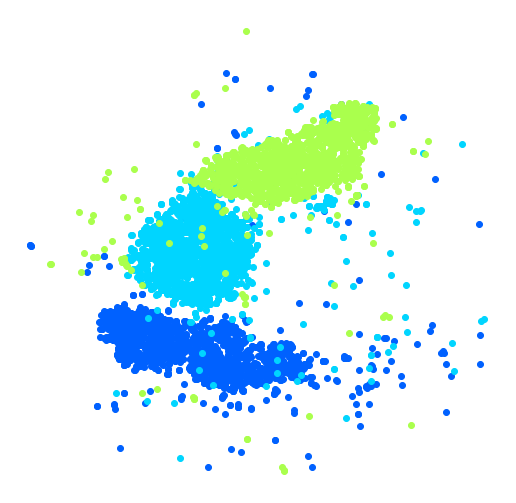

In [19]:
plt.figure(figsize=(9, 9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], 
                c=[cmap(digit / 9)])
plt.axis("off")
plt.show()

In [20]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

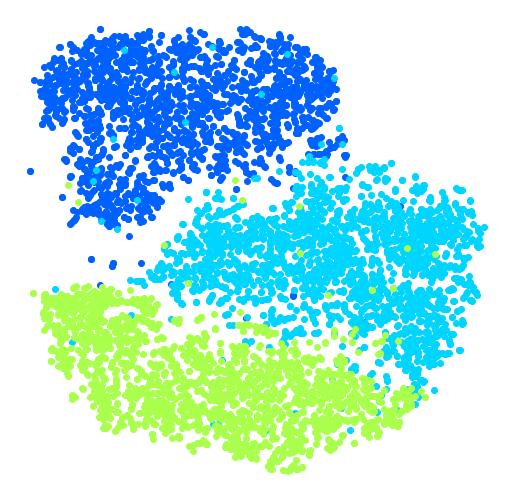

In [21]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], 
                X_subset_reduced[y_subset == digit, 1], 
                c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

<h2> 6. Visualize a few digits from each cluster </h2>

In [22]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Create the list of coordinates of the digits plotted so far.
    # Pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], 
                    c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), 
                                          image_coord)
                ax.add_artist(imagebox)

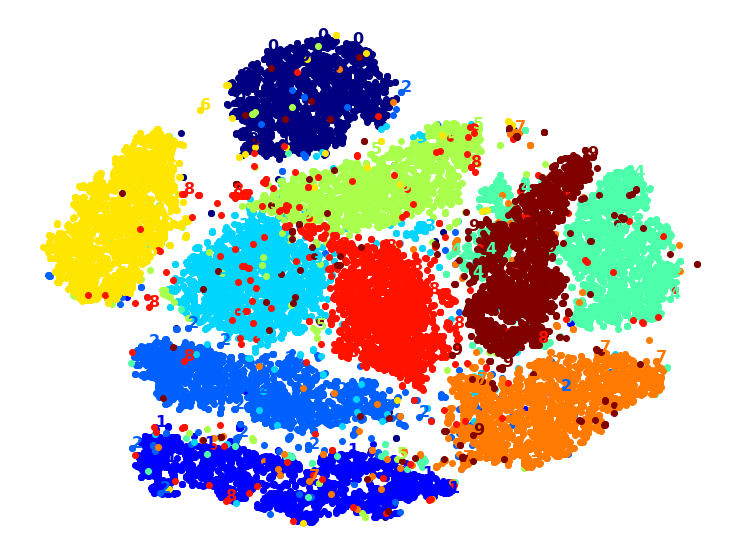

In [23]:
plot_digits(X_reduced, y)

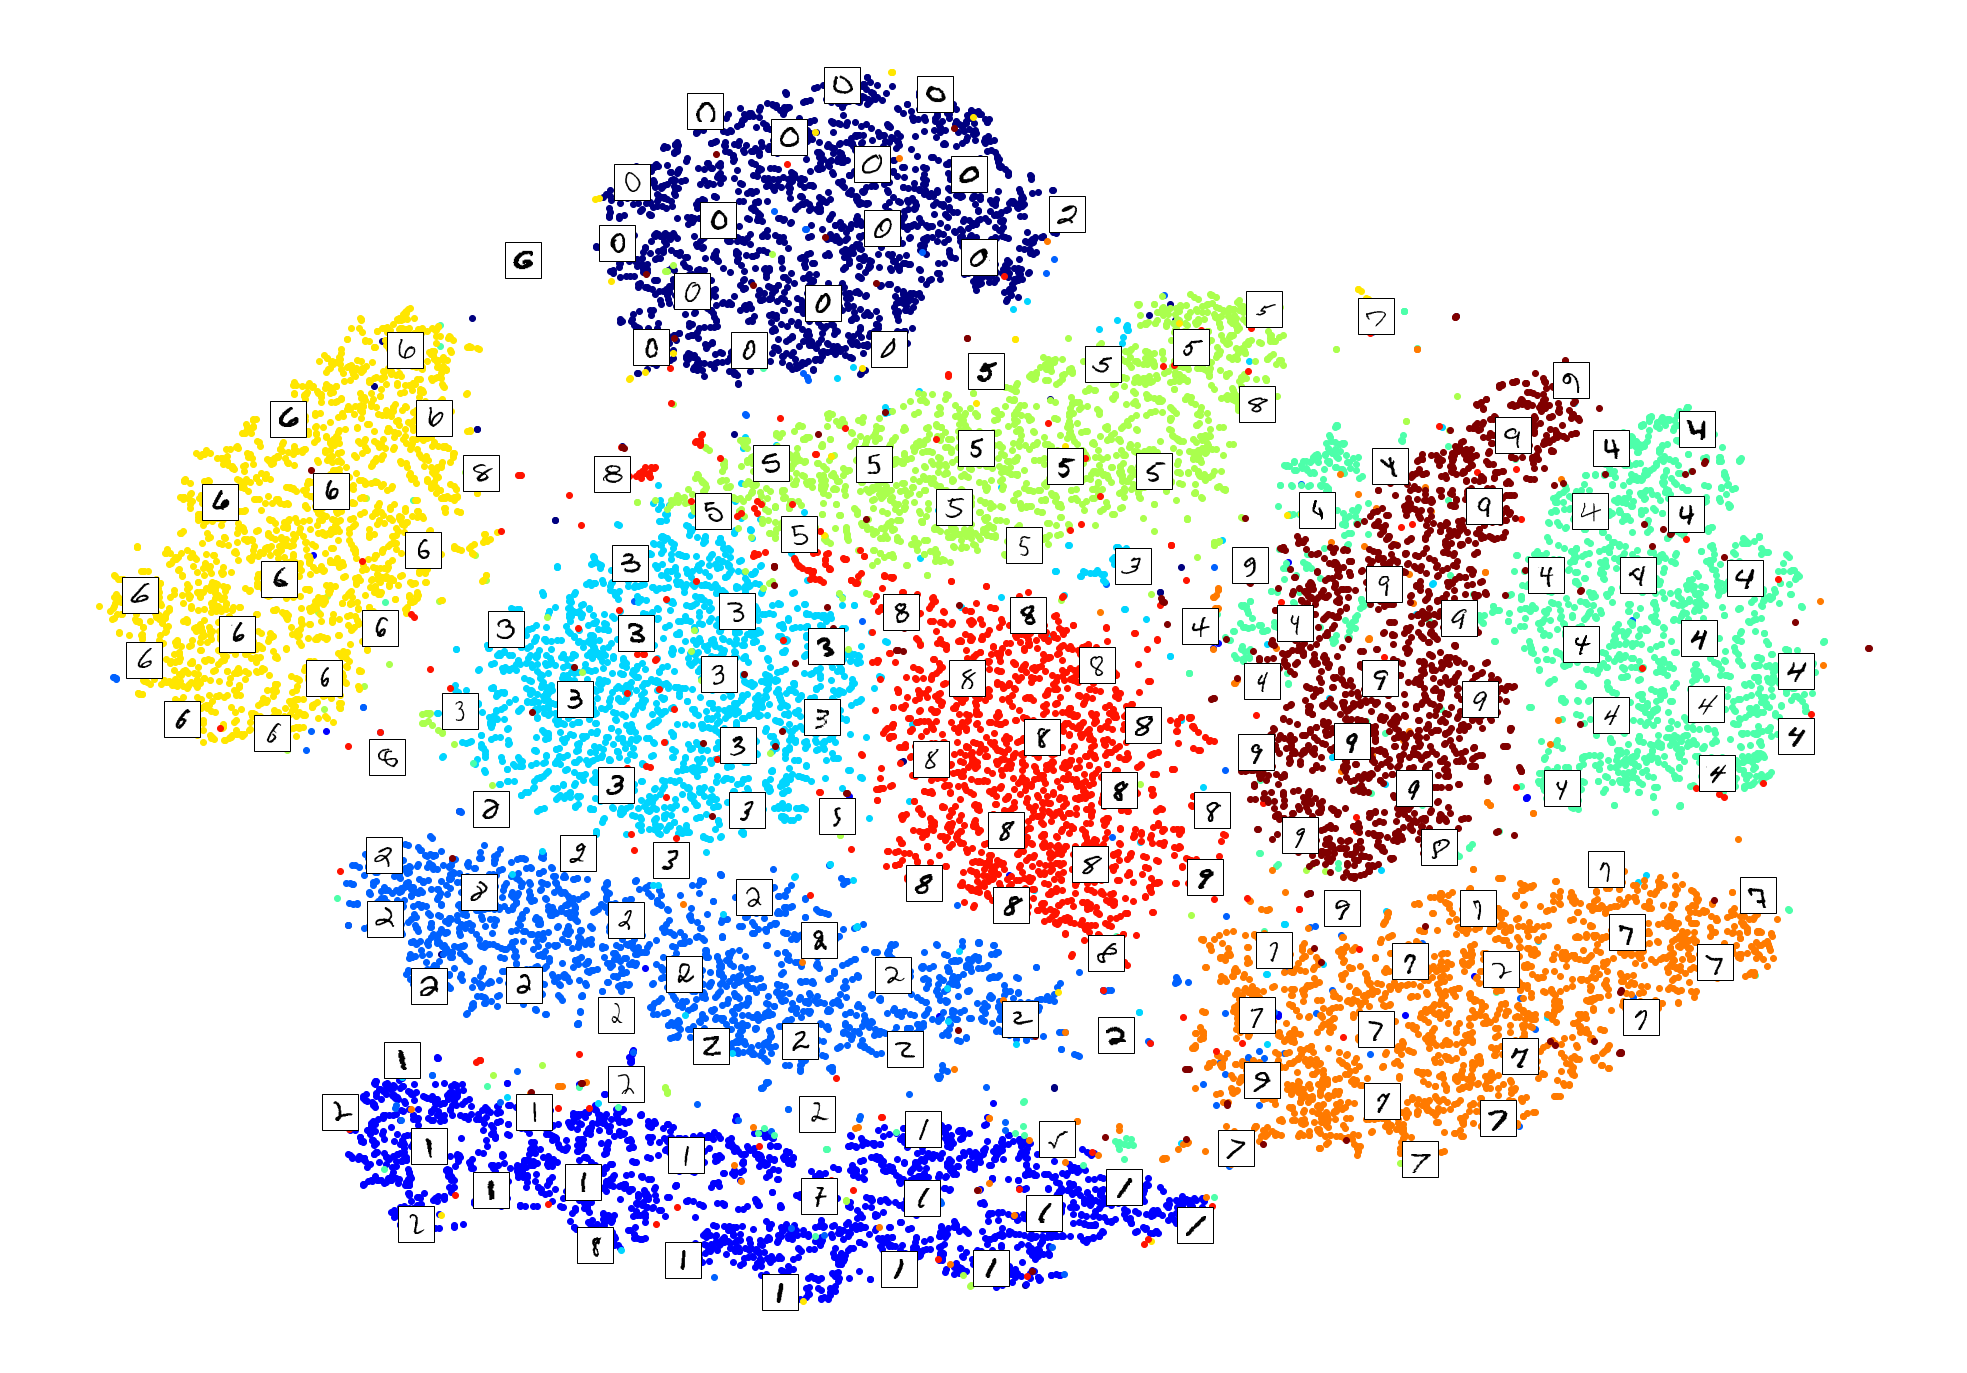

In [24]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

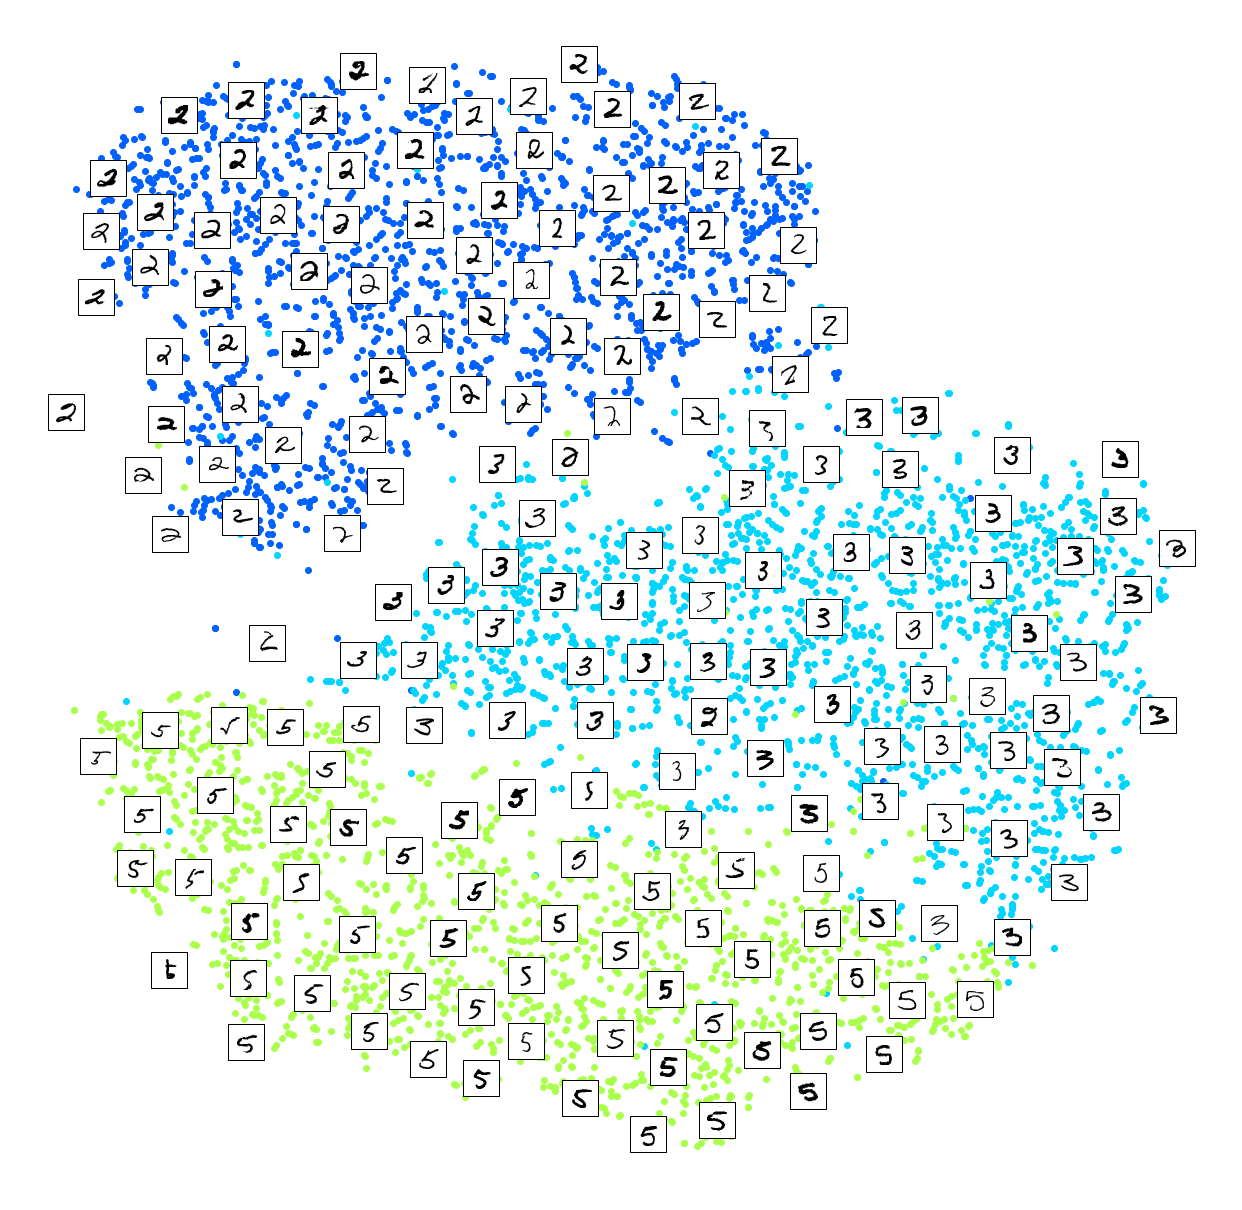

In [25]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

## 7. Using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations

PCA took 0.4s


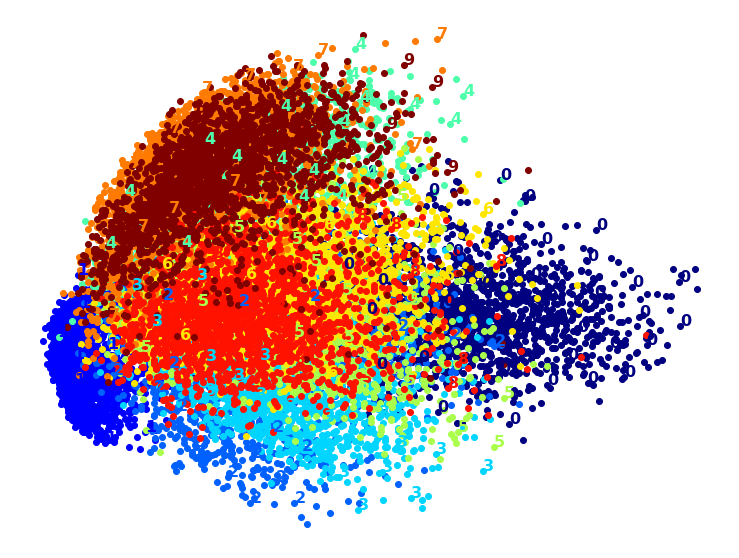

In [26]:
from sklearn.decomposition import PCA
import time

start = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
end = time.time()
print("PCA took {:.1f}s".format(end - start))
plot_digits(X_pca_reduced, y)
plt.show()

LLE took 700.1s


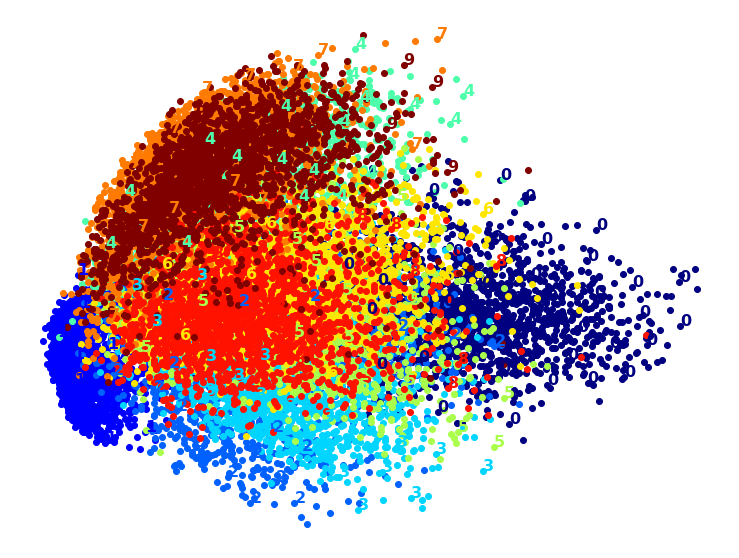

In [27]:
from sklearn.manifold import LocallyLinearEmbedding

start = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
end = time.time()
print("LLE took {:.1f}s".format(end - start))
plot_digits(X_pca_reduced, y)
plt.show()

PCA+LLE took 217.2s.


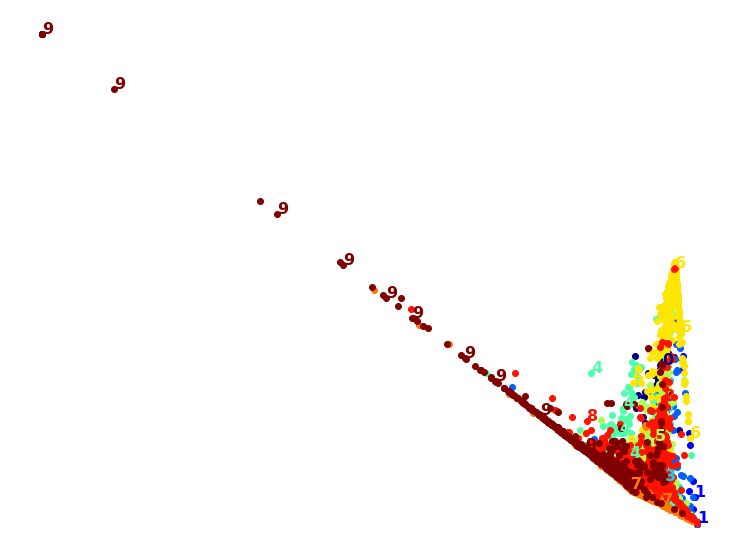

In [28]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
start = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
end = time.time()
print("PCA+LLE took {:.1f}s.".format(end - start))
plot_digits(X_pca_lle_reduced, y)
plt.show()

MDS took 128.0s (on just 2,000 MNIST images instead of 10,000).


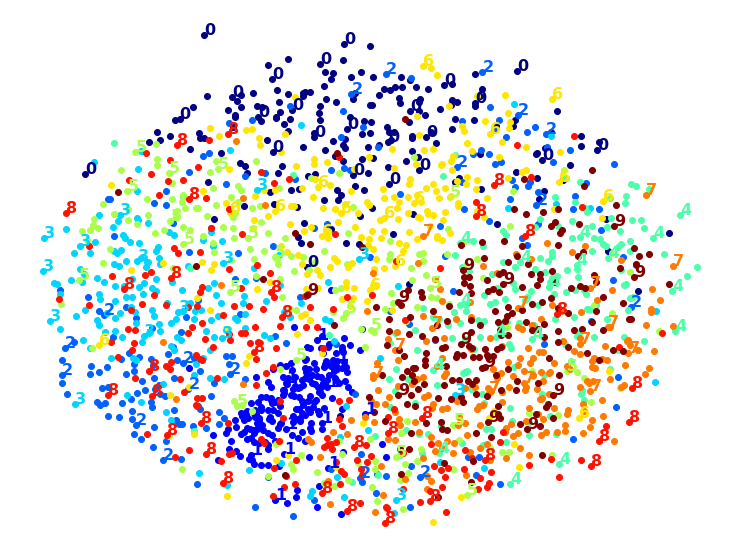

In [29]:
from sklearn.manifold import MDS

m = 2000
start = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
end = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(end - start))
plot_digits(X_mds_reduced, y[:m])
plt.show()

PCA+MDS took 127.7s (on 2,000 MNIST images).


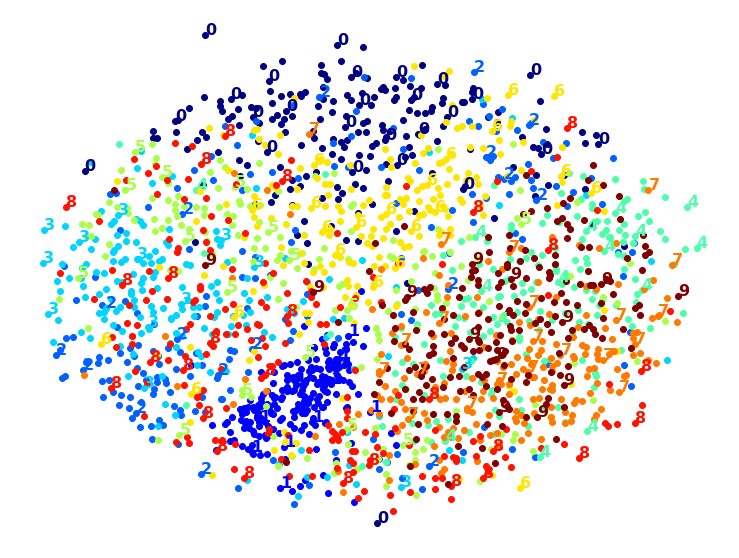

In [30]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
start = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
end = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(end - start))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA took 3.9s.


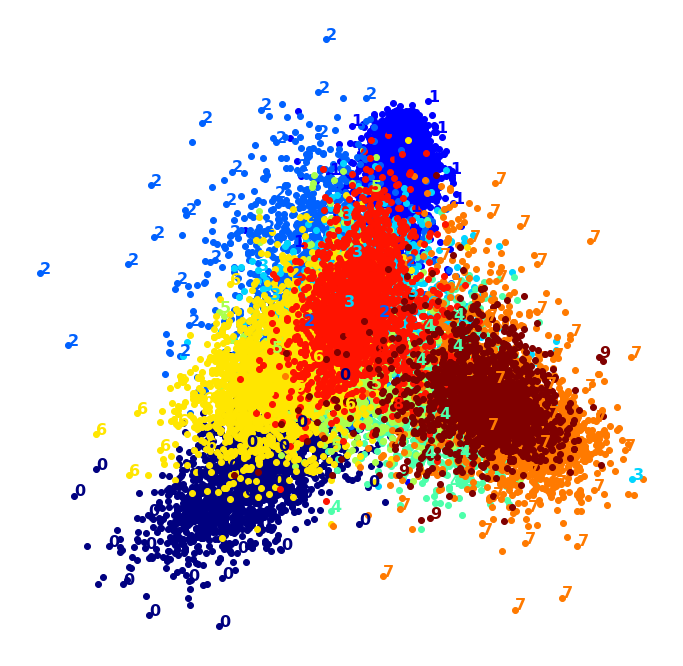

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
end = time.time()
print("LDA took {:.1f}s.".format(end - start))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

t-SNE took 888.7s.


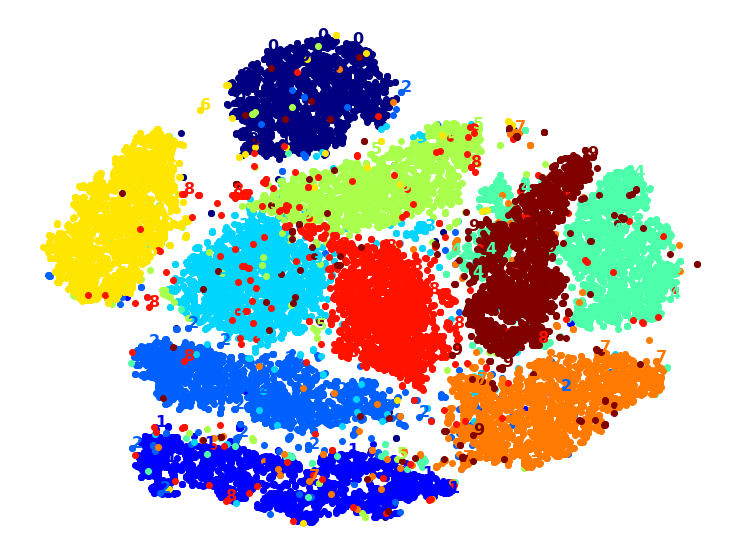

In [32]:
from sklearn.manifold import TSNE

start = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
end = time.time()
print("t-SNE took {:.1f}s.".format(end - start))
plot_digits(X_tsne_reduced, y)
plt.show()

PCA+t-SNE took 405.6s.


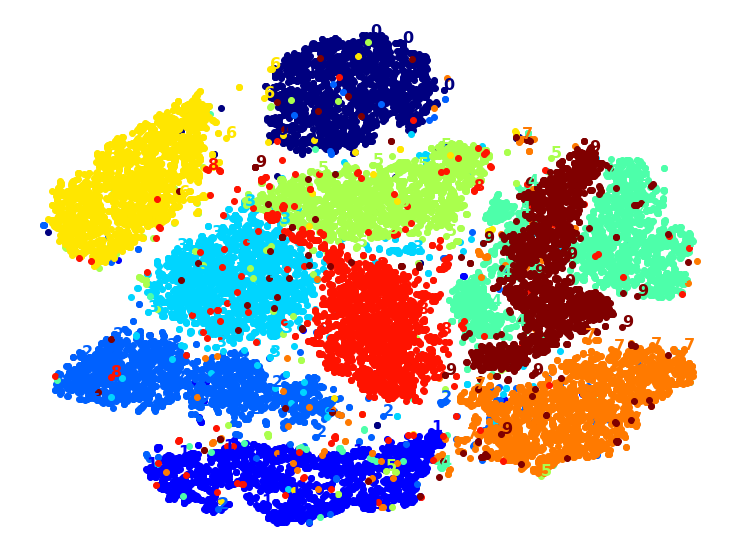

In [33]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
start = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
end = time.time()
print("PCA+t-SNE took {:.1f}s.".format(end - start))
plot_digits(X_pca_tsne_reduced, y)
plt.show()